# Auto-Encoders

In [52]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as VF

## Load MNIST Data

In [53]:
bs = 64
# MNIST Dataset
train_dataset = datasets.MNIST(
    root='~/Datasets/mnist_data/', 
    train=True, 
    transform=transforms.ToTensor(), 
    download=True
    )

test_dataset = datasets.MNIST(
    root='~/Datasets/mnist_data/', 
    train=False, 
    transform=transforms.ToTensor(), 
    download=False
    )

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=bs, shuffle=False)

## Auto-Encoder Model

In [54]:
class AutoEncoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(AutoEncoder, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h)
    
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        z = self.encoder(x.view(-1, 784))
        return self.decoder(z)

# build model
device = torch.device("mps")
ae = AutoEncoder(x_dim=784, h_dim1= 4096, h_dim2=4096, z_dim=8)
ae = ae.to(device)

In [55]:
optimizer = optim.Adam(ae.parameters())
# return reconstruction error
def loss_function(recon_x, x):
    BCE = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    return BCE

In [56]:
def train(epoch):
    ae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch = ae(data)
        loss = loss_function(recon_batch, data)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [57]:
def test():
    ae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon = ae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [58]:
for epoch in range(1, 20):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 181.803635
Train Epoch: 1 [6400/60000 (11%)]	Loss: 37.667747
Train Epoch: 1 [12800/60000 (21%)]	Loss: 27.936255
Train Epoch: 1 [19200/60000 (32%)]	Loss: 24.291628
Train Epoch: 1 [25600/60000 (43%)]	Loss: 20.994799
Train Epoch: 1 [32000/60000 (53%)]	Loss: 18.959499
Train Epoch: 1 [38400/60000 (64%)]	Loss: 19.925854
Train Epoch: 1 [44800/60000 (75%)]	Loss: 15.616465
Train Epoch: 1 [51200/60000 (85%)]	Loss: 16.566799
Train Epoch: 1 [57600/60000 (96%)]	Loss: 15.254263
====> Epoch: 1 Average loss: 23.2836
====> Test set loss: 15.4604
Train Epoch: 2 [0/60000 (0%)]	Loss: 15.166681
Train Epoch: 2 [6400/60000 (11%)]	Loss: 16.013508
Train Epoch: 2 [12800/60000 (21%)]	Loss: 13.374360
Train Epoch: 2 [19200/60000 (32%)]	Loss: 15.548520
Train Epoch: 2 [25600/60000 (43%)]	Loss: 13.623310
Train Epoch: 2 [32000/60000 (53%)]	Loss: 12.640873
Train Epoch: 2 [38400/60000 (64%)]	Loss: 14.879139
Train Epoch: 2 [44800/60000 (75%)]	Loss: 13.856894
Train Epoch: 2 [51200/60000

In [71]:
with torch.no_grad():
    z = (torch.randn(64, 8)*1).to(device)
    sample = ae.decoder(z).to(device)

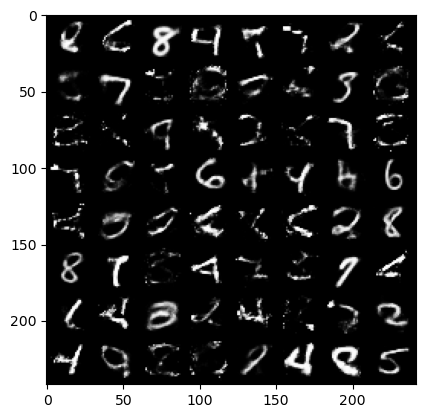

In [70]:
images = sample.view(64, 1, 28, 28).cpu()
grid = make_grid(images)
plt.imshow(grid.permute(1,2,0))

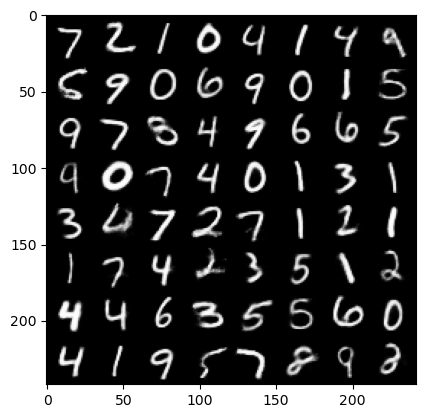

In [61]:
ae.eval()
batch = next(iter(test_loader))[0].to(device)
rec = ae(batch)
images = rec.view(64, 1, 28, 28).cpu()
grid = make_grid(images)
plt.imshow(grid.permute(1,2,0))

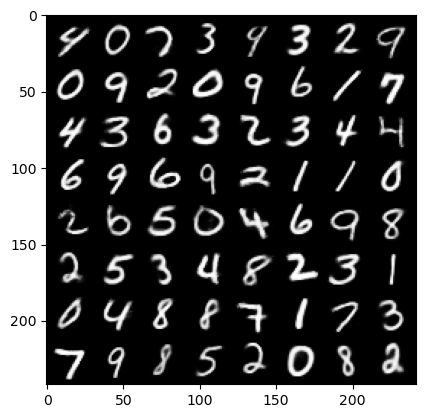

In [62]:
ae.eval()
batch = next(iter(train_loader))[0].to(device)
rec = ae(batch)
images = rec.view(64, 1, 28, 28).cpu()
grid = make_grid(images)
plt.imshow(grid.permute(1,2,0))